# Importing packages

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d
import pptk
from logging import raiseExceptions
import seaborn as sns
import funcs
import tensorflow as tf

%reload_ext funcs


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2022-07-12 17:31:16.789021: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data loader

original dataframe size (1066, 18)
 dataframe (688, 4)


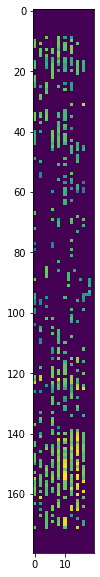

In [2]:
dataloader = funcs.DataLoader(modality='Radar' , data_type='matrix')
dataloader.get_data(filename='1_.txt')

print('original dataframe size', dataloader.dataframe_original.shape)
print(' dataframe',  dataloader.dataframe.shape )

plt.figure(figsize=(50,10))
plt.imshow(dataloader.data_matrix.T / dataloader.data_matrix.max() )

In [3]:
x,y,z = dataloader.spherical_to_cartesian( Azimuth_Angle=dataloader.dataframe.Azimuth , Elevation_Angle=dataloader.dataframe.Elevation - 10 , Range=dataloader.dataframe.Range )

# plt.hist(z)

dataloader.dataframe

,Range,Azimuth,Elevation,RCS
0,1,31,16,85
1,1,54,2,43
2,1,55,2,41
3,1,56,8,40
6,1,57,16,41
...,...,...,...,...
1059,485,40,2,56
1060,496,44,0,61
1061,497,47,12,63
1063,499,46,16,62


In [4]:
# dataloader.dataframe_original

## <span style="color:orange; font-size:0.8em"> Viewing the point clouds </span>

In [5]:
columns = dataloader.dataframe.columns[:3]

funcs.DataLoader().visualize(points=dataloader.dataframe[columns])

## <span style="color:orange; font-size:0.8em"> Vector Input </span>

In [6]:
loader = funcs.VectorInput(filename='1_.txt', modality='Radar')

print(loader.dataframe.shape)
print(loader.data.test.shape)

2022-07-12 17:31:22.310808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 17:31:22.357484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-12 17:31:22.357528: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-12 17:31:22.358529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Epoch 1/5
13/13 [==============================] - 1s 52ms/step - loss: -941.1397 - val_loss: -996.6763
Epoch 2/5
13/13 [==============================] - 0s 25ms/step - loss: -998.3820 - val_loss: -996.6763
Epoch 3/5
13/13 [==============================] - 0s 25ms/step - loss: -998.3820 - val_loss: -996.6763
Epoch 4/5
13/13 [==============================] - 0s 25ms/step - loss: -998.3821 - val_loss: -996.6763
Epoch 5/5
7/7 [==============================] - 0s 8ms/step
(688, 4)
(220, 4)


## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [27]:
loader = funcs.MatrixInput(modality='Radar')

Epoch 1/5
32/32 [==============================] - 2s 39ms/step - loss: 0.5322 - val_loss: 0.3706
Epoch 2/5
32/32 [==============================] - 1s 32ms/step - loss: 0.3503 - val_loss: 0.3237
Epoch 3/5
32/32 [==============================] - 1s 32ms/step - loss: 0.3022 - val_loss: 0.2860
Epoch 4/5
32/32 [==============================] - 1s 32ms/step - loss: 0.2811 - val_loss: 0.2777
Epoch 5/5
32/32 [==============================] - 0s 10ms/step


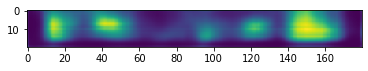

In [28]:
plt.imshow(loader.predictions[0,...])

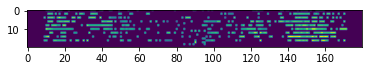

In [29]:
plt.imshow(loader.dataset[0,...])

In [19]:
plt.imshow(list(loader.data.test.take(1))[0].numpy() )
plt.show()

AttributeError: 'tuple' object has no attribute 'numpy'